In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
# from utils import *

04_16_25


In [2]:
import sys
# sys.path.append('/path/to/the/folder/of/your/module/file')
sys.path

['/Users/maryumsayeed/Desktop/Code/Research/espresso_lirich/scripts',
 '/opt/miniconda3/lib/python39.zip',
 '/opt/miniconda3/lib/python3.9',
 '/opt/miniconda3/lib/python3.9/lib-dynload',
 '',
 '/opt/miniconda3/lib/python3.9/site-packages',
 '/opt/miniconda3/lib/python3.9/site-packages/certifi-2022.9.24-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/ipython_genutils-0.2.0-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/fits2hdf-1.1.1-py3.9.egg',
 '/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions',
 '/Users/maryumsayeed/.ipython']

In [3]:
#pip install thejoker

In [4]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az

In [16]:
files = glob.glob('../data/p112_data/*.fits')
# files = glob.glob('../data/spectra/*.fits')

In [6]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
# galah=get_galah()

In [7]:
# galah

In [8]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [9]:
# spectrum = fits.open('../data/spectra/archive/ADP.2023-12-08T12:58:09.704.fits')
# header = spectrum[0].header
# data   = spectrum[1].data

In [10]:
# instrument precision: cm/s
# decription of columns: https://ftp.eso.org/pub/dfs/pipelines/instruments/espresso-das/espda-reflex-tutorial-1.3.7.pdf
# QC CCF RV: computed radial velocity [km s−1

In [11]:
# from: https://www.eso.org/rm/api/v1/public/releaseDescriptions/176
# Barycentric correction. The wavelengths in the science spectrum are correct to the barycentre of
# the solar system. 

In [20]:
hdul = fits.open(files[0])
hdul
header  = hdul[0].header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-04-08T08:28:23' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
OBJECT  = 'UCAC4 202-005918'   / Original target.                               
RA      =            81.645124 / [deg] Spectroscopic target position (J2000)    
DEC     =            -49.78464 / [deg] Spectroscopic target position (J2000)    
EXPTIME =                 300. / [s] Total integration time per pixel           
MJD-OBS =       60373.013403

In [ ]:
ss

In [12]:
# header.cards

In [13]:
obj_dir = {}
c=3e5 #km/s

for i,file in enumerate(files):
    with fits.open(file) as hdul:
        hdul = fits.open(file)
        header  = hdul[0].header
        #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
        data    = hdul[1].data
        time    = header['HIERARCH ESO QC BJD']
        name    = header['OBJECT']
        obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
        #print(obj)
        ra,dec  = header['RA'], header['DEC']
        obs_T   = header['DATE-OBS'].split('T')[0]
        rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
        rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
        sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        rv_corr = rv_val
        err_corr = rv_err
        # correct for Earth's motion:
#         rv_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value #to convert to km/s
#         err_corr = sc.radial_velocity_correction(kind='barycentric', obstime=Time(obs_T), location=vlt).to(u.km/u.s).value
#         rv_corr = rv_val + rv_corr + rv_val * rv_corr / c  
        #err_corr = rv_err + err_corr + rv_err * err_corr / c  
        
        if obj in obj_dir.keys():
            obj_dir[obj]['rv'].append(rv_corr)
            obj_dir[obj]['time'].append(time)
            obj_dir[obj]['err'].append(err_corr)
            obj_dir[obj]['name'].append(name)
        else:
            obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 'name': [name]}
            
targets_to_remove = []
for k, v in obj_dir.items():
    if len(v['time']) < 3:
        targets_to_remove.append(k)
for i in range(len(targets_to_remove)):
    del obj_dir[targets_to_remove[i]]
print(len(obj_dir.keys()))

myKeys = list(obj_dir.keys())
myKeys.sort()
obj_dir = {i: obj_dir[i] for i in myKeys}
 

10


In [14]:
obj_dir

{1: {'rv': [53.7010931002614,
   53.7985038354756,
   53.6662146276548,
   53.7157728358864,
   53.4587722172283],
  'time': [2460341.53519178,
   2460389.56581584,
   2460360.69465003,
   2460371.51348333,
   2460303.84853621],
  'err': [0.0356353249891873,
   0.0194215970708735,
   0.037652977918329,
   0.01884311301645,
   0.0061571780501783],
  'name': ['UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956',
   'UCAC4 297-057956']},
 2: {'rv': [32.3479397396596,
   32.2219401343109,
   32.1287798102999,
   32.4346525203479,
   32.2407984317867],
  'time': [2460371.51618373,
   2460396.54486059,
   2460327.53578864,
   2460346.537628,
   2460299.52949389],
  'err': [0.0162974981805524,
   0.0156970104026681,
   0.00562990000726012,
   0.0238086986750946,
   0.00799784331266222],
  'name': ['UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674',
   'UCAC4 159-007674']},
 4: {'rv': [50.1334256209368,
   49.643055167163,

In [15]:
galah_dir = {
    1: 150107004201104,
    2: 151230003202196,
    4: 161013005401317,
    5: 161104004801189,
    6: 150829004301285,
    7: 160129003601260,
    13: 190212001601338,
    14: 140311007101261,
    23: 170514002101318,
    24: 171208003602294
}

In [16]:
new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}
for k, v in galah_dir.items():
    new_df['RG_id'].append(k)
    new_df['galah_id'].append(v)
    new_df['obj_name'].append(obj_dir[k]['name'][0])
    

new_df = pd.DataFrame(new_df)
new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05


1 0.16986580912364957
2 0.15293635502399994
4 0.2451852268868997
5 0.580356837546951
6 0.6518581581411201
7 0.33829807786749
13 14.615809339959851
14 0.17943440233025143
23 6.39697151489245
24 0.14459279697440053


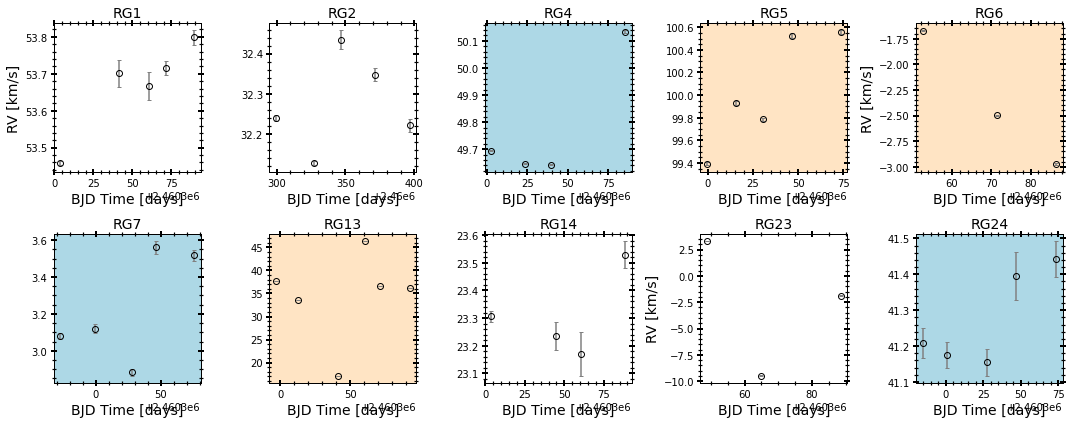

In [17]:
#PLOT_PARAMS(LS=12)
plt.figure(figsize=(15,6))
for i, (obj, dat) in enumerate(obj_dir.items()):
    if len(dat['time']) > 1:
        #print(obj,obj_dir[obj])
        ax=plt.subplot(2,5,i+1)
        time    = np.array(obj_dir[obj]['time'])
        rv_vals = np.array(obj_dir[obj]['rv'])
        t0  = time[0]
        rv0 = rv_vals[0]
        K0 = (max(rv_vals)-min(rv_vals))/2.
        yerr = obj_dir[obj]['err']
        print(obj, K0)
        plt.errorbar(time, rv_vals, 
                     yerr=yerr,
                     fmt='o', color='grey', mec='k', mfc='None', capsize=2)
        #plt.axhline(0, color='k',lw=1,ls='dotted')
        title = 'RG%s'%obj
        plt.title(title)
        if title in ['RG13','RG5','RG6']:
            ax.set_facecolor('bisque')
        elif title in ['RG4','RG24','RG13','RG7']:
            ax.set_facecolor('lightblue')
    plt.xlabel(r'BJD Time [days]')
    if i+1 in [1,5,9,13]: plt.ylabel(r'RV [km/s]')

plt.tight_layout()
# plt.savefig('../plots/init_%s.png'%DATE, bbox_inches='tight', dpi=200)

In [18]:
ss

NameError: name 'ss' is not defined

In [ ]:
def test_tj(obj,prior_size=50_000,save=False,MCMC=False):
    data = Table()
    data['bjd'] = obj_dir[obj]['time']
    data['rv'] = obj_dir[obj]['rv']
    data['rv_err'] = obj_dir[obj]['err']
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        P_prior = xu.with_unit(pm.Uniform("P", 2, 5e3), u.day)
        K_prior = xu.with_unit(pm.Normal("K", 0, 10), u.km/u.s)
        prior = tj.JokerPrior.default(
                #P_min=2 * u.day,
                #P_max=1e3 * u.day,
                sigma_K0=10 * u.km / u.s,
                sigma_v=100 * u.km / u.s,
                pars={'P':P_prior, 'K':K_prior}
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    
    PLOT_PARAMS()
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=1000, draws=1000, start=mcmc_init, cores=1, chains=2)

        az.summary(trace, var_names=prior.par_names)
        
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        truth = ['P','e','omega','M0','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples



In [ ]:
ps, js = test_tj(13, prior_size=250_000, save=True, MCMC=True)#,save=True,MCMC=True)

In [ ]:
_=plt.hist(js[1],bins='auto')
plt.xlabel('Joker Samples')
plt.yscale('log')


In [ ]:
ss

In [ ]:
binaries = [23, 13, 7, 6, 5, 4, 1]
for star_id in binaries[1:]:#list(obj_dir.keys()):
    print(star_id)
    test_tj(star_id, prior_size=250_000, save=True, MCMC=True)#,save=True,MCMC=True)

In [ ]:
ts1, ts2 = test_tj(13,prior_size=50_000,save=False,MCMC=False)

In [ ]:
_=plt.hist(ts1[1],bins='auto')
_=plt.hist(ts2[1],bins='auto')
plt.yscale('log')


In [ ]:
test_tj(13,prior_size=50_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=2_500_000,save=False,MCMC=True)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
plt.hist(prior_samples_dict[13]['P'].to_value())


In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=False)

In [ ]:
test_tj(13,prior_size=250_000,save=False,MCMC=True)

In [ ]:
prior_samples_dict = dict.fromkeys(obj_dir)
joker_samples_dict = dict.fromkeys(obj_dir)
for ob in list(obj_dir.keys())[1:]:
    ps, js = test_tj(ob,prior_size=250_000,save=False,MCMC=True)
    prior_samples_dict[ob] = ps
    joker_samples_dict[ob] = js
    

In [ ]:
joker_samples_dict[6]

In [ ]:
plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P']):
    plt.subplot(2,3,i+1)
    plt.hist(prior_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()

plt.figure()
for i,param in enumerate(['e', 'omega', 'M0', 's', 'P','K','v0']):
    plt.subplot(3,3,i+1)
    plt.hist(joker_samples_dict[5][param].to_value())
    plt.title(param)
plt.tight_layout()